In [1]:
% matplotlib inline

UsageError: Line magic function `%` not found.


# Diseño y construcción de red bayesiana

Ejercicio de _Bayesian Networks_ de Pekka Parviainen.

Supongamos que todos los días para ir a trabajar tengo que coger el autobús. Hay diversos factores que inciden en que llegue puntual al trabajo y mi jefe quiere saber la probabilidad de que sea puntual en función de si el autobús se retrasó o de si la alarma del despertador no funcionó correctamente. Todo ello lo va a calcular a partir del conocimiento probabilístico que tiene.

Mi despertador suele funcionar bien, pero a veces no se activa (debería comprar otro...). El que funcione o no el despertador incide mucho en que yo me despierte a la hora o me quede dormido. El autobús también suele llegar en hora, aunque a veces el tráfico hace que llegue tarde. Tanto el que yo me quede dormido, como el que el autobús llegue en hora, afecta a que yo llegue puntual al trabajo.

Las probabilidades de cada evento son:

- La probabilidad de que el **despertador suene** es, de media, el 90%.
- La probabilidad de que el **autobús llegue tarde** es del 20%.
- Si el despertador suena, el 90% de las ocasiones me despierto en hora, pero el 10% de las ocasiones me **quedo dormido**.
- Si el autobús llega tarde y yo me quedo dormido, es probable que no llegue **puntual al trabajo**, más concretamente:
  - Si el autobús llega tarde y yo me quedo dormido, la probabilidad de llegar puntual al trabajo es del 10%; mientras que si el autobús llega tarde pero yo no me quedo dormido, la probabilidad es del 20%.
  - Si el autobús llega puntual y yo me quedo dormido, la probabilidad de llegar puntual es del 30%, mientras que si no me he dormido y el autobús llega en hora, la probabilidad de llegar puntual al trabajo es del 90%.

Nota: los nodos de la red bayesiana se han resaltado en negrita para facilitar su identificación.

## Práctica a realizar

Diseñar una red bayesiana que recoja la información planteada en el ejercicio. Dibujarla e insertar dicha imagen en el notebook.

Utilizando la biblioteca `pymc3` de Python modelar la red bayesiana planteada y responder a las siguientes cuestiones:
- Sabiendo que he llegado puntual al trabajo: ¿cuál es la probabilidad de que el despertador haya sonado? ¿cuál es la probabilidad de que el autobús haya llegado tarde?
- Explica y/o razona los cálculos realizados y si hay nodos de dicha red que no son útiles para las dos cuestiones previas.


A continuación se muestra la red diseñada:

![title](./RedBayesiana.png)

En negrita se resaltan las probabilidades obtenidas del enunciado, y en cursiva las inferidas. Se representan en color azul los nodos sin ninguna probabilidad condicionada, mientras que nos verdes son los que sí que cuentan con ellas.

In [2]:
# cargamos las bibliotecas necesarias
import pymc3 as pm
import numpy as np
import pandas as pd

# Muestras a "lanzar".
num_muestras = 10000
# Muestras descartadas al inicio para ajustar.
num_descartes = 1000

#cargamos el modelo que contandrá todas la variables aleatorias del problema
modelo = pm.Model()

WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


El siguiente paso será definir la totalidad de las variables aleatorias identificadas en la red presentada al inicio. Durante el siguiente bloque se describen los pasos realizados por medio de comentarios para facilitar el seguimiento.

- Es importante comentar que las variables se definen siguiendo una distribución Bernoulli  truncando las probabilidades
- Para definir una variable condicionada se utiliza `pm.Deterministic(nombre, transformación_variable)`, que permite realizar diferentes transformaciones sobre una variable aleatoria. En caso de estar condicionada por un solo nodo solo se necesita una transformación (`switch`), en caso de dos variables (`llegar_puntual`), van a ser necesarias dos transformaciones.

In [3]:
with modelo:    
    tv = [1]

    # probabilidad de que el despertador suene del 90% (sigue una distribución Bernoulli truncando el porcentaje)
    despertador_suena = pm.Bernoulli('despertador_suena', 0.9, shape=1, testval=tv)
    # se genera un muestreo de aleatorio quedándonos con los 100 primeros
    # trace_despertador_suena = pm.sample(100, tune=500)
    
    # probabilidad de que el bus llegue tarde del 20%
    bus_tarde = pm.Bernoulli('bus_tarde', 0.2, shape=1, testval=tv)
    # se genera un muestreo de aleatorio quedándonos con los 100 primeros
    # trace_bus_tarde = pm.sample(100, tune=500)

    # creamos la variable aleatoria quedarse_dormido a partir de despertador_suena
    #    despertador suena => 0.1 de quedarse dormido
    #   despertador no suena => 0.9 de quedarse dormido
    quedarse_dormido_p = pm.Deterministic('quedarse_dormido_p',  pm.math.switch(despertador_suena, 0.1, 0.9))
    # se crea la variable quedarse_dormido utilizando la tabla de probabilidades de la variable aleatoria
    #    transformada anterior (quedarse_dormido_p)
    quedarse_dormido = pm.Bernoulli('quedarse_dormido', quedarse_dormido_p, shape=1, testval=tv)
    # se genera un muestreo de aleatorio quedándonos con los 100 primeros
    # trace_quedarse_dormido = pm.sample(100, tune=500)
    
    # creamos la variable aleatoria llegar_puntual a partir de quedarse_dormido y bus_tarde
    # de la misma manera que quedarse_dormido pero utilizando 2 swtiches (2 variables):
    #   
    # llegar_puntual: si bus_tarde y quedarse_dormido 10%, si bus_tarde y no quedarse_dormido 20%, 
    #                 no bus_tarde y quedarse_dormido 30%, no bus_tarde y no quedarse_dormido 90%
    llegar_puntual_p = pm.Deterministic('llegar_puntual_p', 
                pm.math.switch(bus_tarde, pm.math.switch(quedarse_dormido, 0.1, 0.2),
                               pm.math.switch(quedarse_dormido, 0.3, 0.9)))
    llegar_puntual = pm.Bernoulli('llegar_puntual', llegar_puntual_p,
                             observed=np.array([1]), shape=1)
    
    # se genera un experimento utilizando el método BinaryGibbsMetropolisResolver
    #    variando bus_tarde y quedarse_dormido.
    trace = pm.sample(num_muestras, step=[pm.BinaryGibbsMetropolis([bus_tarde, quedarse_dormido])], 
                      tune=num_descartes, random_seed=1)

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>BinaryGibbsMetropolis: [bus_tarde, quedarse_dormido]
>BinaryGibbsMetropolis: [despertador_suena]
Sampling 4 chains, 0 divergences: 100%|██████████| 44000/44000 [00:06<00:00, 6567.73draws/s]


Se muestra la información del experimento diseñado, analizándo los resultados de manera gráfica:

/home/david/anaconda3/lib/python3.8/site-packages/arviz/data/io_pymc3.py:87: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fc471285070>,
      dtype=object)

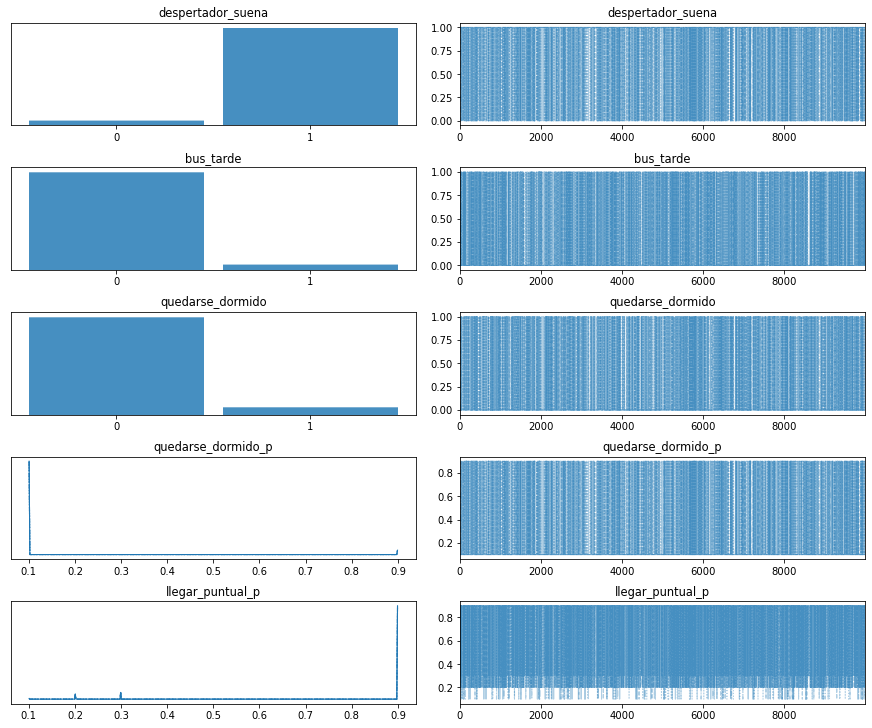

In [4]:
pm.traceplot(trace)

Se muestran algunas de las variables

In [5]:
trace['despertador_suena']

array([[1],
       [1],
       [1],
       ...,
       [1],
       [1],
       [0]])

In [6]:
trace['bus_tarde']

array([[0],
       [1],
       [0],
       ...,
       [0],
       [1],
       [0]])

In [7]:
trace['quedarse_dormido_p']

array([[0.1],
       [0.1],
       [0.1],
       ...,
       [0.1],
       [0.1],
       [0.9]])

In [8]:
trace['quedarse_dormido']

array([[0],
       [0],
       [0],
       ...,
       [0],
       [0],
       [1]])

Se crea un *dataframe* en Pandas con los valores de cada una de las variables aleatorias:

In [9]:
dictionary = {
    'despertador_suena': 
         [1 if ii[0] else 0 for ii in trace['despertador_suena'].tolist() ],
    'bus_tarde': 
         [1 if ii[0] else 0 for ii in trace['bus_tarde'].tolist() ],
    'quedarse_dormido': 
         [1 if ii[0] else 0 for ii in trace['quedarse_dormido'].tolist() ],
    'quedarse_dormido_p': 
         [ii[0] for ii in trace['quedarse_dormido_p'].tolist()],
    'llegar_puntual_p': 
         [ii[0] for ii in trace['llegar_puntual_p'].tolist()],
}
df = pd.DataFrame(dictionary)

Se muestra el nuevo *dataframe* creado:

In [10]:
df

,despertador_suena,bus_tarde,quedarse_dormido,quedarse_dormido_p,llegar_puntual_p
0,1,0,0,0.1,0.9
1,1,1,0,0.1,0.2
2,1,0,0,0.1,0.9
3,1,0,0,0.1,0.9
4,1,0,0,0.1,0.9
...,...,...,...,...,...
39995,1,0,0,0.1,0.9
39996,1,0,0,0.1,0.9
39997,1,0,0,0.1,0.9
39998,1,1,0,0.1,0.2


## Preguntas

**1. Sabiendo que he llegado puntual al trabajo: ¿cuál es la probabilidad de que el despertador haya sonado? ¿cuál es la probabilidad de que el autobús haya llegado tarde?**

In [11]:
# buscamos en la tabla los resultados donde haya sonado el despertador
#   y dividimos por el tamaño de la tabla para obtener el porcentaje
p_despertador_suena = df[(df['despertador_suena'] == 1)].shape[0] / df.shape[0]
print("\nProbabilidad de que haya sonado el despertador :", p_despertador_suena)

# Sumar las filas en las que el bus haya llegado tarde está a 1 y dividir entre el número total de filas.
p_bus_tarde = df[(df['bus_tarde'] == 1)].shape[0] / df.shape[0]
print("\nProbabilidad de que el bus haya llegado tarde :", p_bus_tarde)


Probabilidad de que haya sonado el despertador : 0.952975

Probabilidad de que el bus haya llegado tarde : 0.052475


De acuerdo a los resultados de la red bayesiana, si hemos llegado puntuales al trabajo, la probabilidad de que  haya sonado el despertador es de un **95%**, y de que el bus haya llegado tarde de un **5%**.

Por ejemplo, si quisiéramos saber la probabilidad de que se haya quedado dormido habiendo llegado puntual, solo sería necesario quedarse con los resultados en donde se haya quedado dormido (`quedarse_dormido == True`):

In [12]:
p_quedarse_dormido = df[(df['quedarse_dormido'] == 1)].shape[0] / df.shape[0]
print("\nProbabilidad de que se haya quedado dormido:", p_quedarse_dormido)


Probabilidad de que se haya quedado dormido: 0.070975


**2. Explica y/o razona los cálculos realizados y si hay nodos de dicha red que no son útiles para las dos cuestiones previas.**

Para llegar a los resultados fueron necesarios una serie de pasos necesarios a seguir:
- diseñar la red bayesiana en el enunciado
- crear las diferentes variables aleatorias (identificadas como los nodos de la red), diferenciando las variables sin condiciones (simples distribuciones de Bornoulli truncando las probabilidades para adaptarlas al enunciado) y las variables aleatorias condicionadas (necesario utilizar `pm.Deterministic` para aplicar las transformaciones necesarias)
- se define una muestra de ejemplo variando las variables que condicionan la probabilidad de `llegar_puntual` (`bus_tarde`, `quedarse_dormido`) y a partir de estos resultados se obtiene un *dataframe* para facilitar los cálculos


Este *dataframe* nos presenta diferentes valores (posibilidades) para cada una de las variables aleatorias para llegar puntual al trabajo. A partir de ahí, solo es necesario seleccionar una de las variables para saber la probabilidad que haya sido correcta.

Por ejemplo la probabilidad de que llegando puntual, haya sonado la alarma. Solo es necesario seleccionar la variable de sonar la alarma (`despertador_suena`) cuando sea cierto (`despertador_suena` == 1).

El siguiente punto a comentar es el análisis de la red bayesiana diseñada para saber si hay nodos que no son útiles para las preguntas anteriores (**probabilidad de que el despertador haya sonado** y **probabilidad de que el bus haya llegado tarde**). Aunque parezca que el nodo de `quedarse_dormido` no es importante, realmente los nodos que condiciona el hecho de llegar puntual es `bus_tarde` y `quedarse_dormido`. La probabilidad de llegar puntual está condicionada por la probabilidad de que el bus llegue tarde y la probabilidad de quedarse dormido, no podemos obtener la probabilidad de llegar puntual si solo se condiciona con el nodo de `bus_tarde` o solo con la de `quedarse_dormido`:

- en la pregunta de la probabilidad de `bus_tarde`, las variables de `llegar_puntual` y `bus_tarde` son condicionalmente dependientes dado `quedarse_dormido`. Ambos nodos están d-separados.

En cuanto a la probabilidad de que el despertador haya sonado habiendo llegado puntual, la probabilidad de llegar puntual está condicionada por dos variables que son condicionalmente dependientes, por lo que creo que no se puede eliminar ningún nodo (nodos que condicionan de forma directa la probabilidad de llegar puntual). En caso de conocer por ejemplo, la probabilidad de llegar puntual sin estar condicionada por el nodo `bus_tarde`, se podría prescindir de éste. Pero en tanto que ninguno de los hijos es a priori conocido, la evidencia no puede ser transmitida.